# Introduction

Setting up the environment for the project to be run.

In [2]:
!nvidia-smi

Tue Mar 11 19:22:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!pip install -q gdown inference-gpu
!pip install -q git+https://github.com/roboflow/sports.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.6/999.6 kB 28.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [6]:
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /kaggle/working/121364_0.mp4
100%|██████████████████████████████████████| 17.2M/17.2M [00:00<00:00, 63.0MB/s]


In [7]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"  

In [8]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
TARGET_VIDEO_PATH = "/kaggle/working/121364_0_result.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30
PLAYER_IN_POSSESSION_PROXIMITY = 40

In [46]:
import io
import sys
import cv2
import umap
import time
import torch
import logging
import contextlib
import numpy as np
import pandas as pd
import supervision as sv


from collections import deque
from inference import get_model
from kaggle_secrets import UserSecretsClient
from google.colab import userdata 
from tqdm import tqdm
from more_itertools import chunked
from sklearn.cluster import KMeans
from typing import Optional
from transformers import AutoProcessor, SiglipVisionModel
from sports.common.team import TeamClassifier
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_paths_on_pitch,
    draw_pitch_voronoi_diagram
)


In [11]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
offside_ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#34eb49', '#64f5f0']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)
player_triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#072D69'),
    base=20, height=17
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)
offside_label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#34eb49', '#64f5f0']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

In [12]:
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("Roboflow")

In [13]:
class FrameDetections:
    def __init__(self,frame, detections, tracker, team_classifier, 
                 BALL_ID=0, GOALKEEPER_ID=1, PLAYER_ID=2, REFEREE_ID=3,pad_px=10, nms_threshold=0.5):
        
        self.frame = frame
        self.detections = detections
        self.tracker = tracker
        self.BALL_ID = BALL_ID
        self.GOALKEEPER_ID = GOALKEEPER_ID
        self.PLAYER_ID = PLAYER_ID
        self.REFEREE_ID = REFEREE_ID
        self.pad_px = pad_px
        self.nms_threshold = nms_threshold
        self.team_classifier = team_classifier
        
        # 1. Process the detections when initializing the class.
        self.ball_detections = self.detections[self.detections.class_id == self.BALL_ID]
        self.ball_detections.xyxy = sv.pad_boxes(xyxy=self.ball_detections.xyxy, px=self.pad_px) 
    
        # 2. Process non-ball detections with NMS and tracker update
        self.all_detections = self.detections[self.detections.class_id != self.BALL_ID]
        self.all_detections = self.all_detections.with_nms(threshold=self.nms_threshold, class_agnostic=True)
        self.all_detections = self.tracker.update_with_detections(detections=self.all_detections)
        
        # 3. Separate goalkeepers, players and referees detections
        self.goalkeepers_detections = self.all_detections[self.all_detections.class_id == self.GOALKEEPER_ID]
        self.players_detections = self.all_detections[self.all_detections.class_id == self.PLAYER_ID]
        self.referees_detections = self.all_detections[self.all_detections.class_id == self.REFEREE_ID]

        # 4. Crop player images and classify team (suppress stderr output during prediction)
        players_crops = [sv.crop_image(self.frame, xyxy) for xyxy in self.players_detections.xyxy]
        with contextlib.redirect_stderr(io.StringIO()):
            self.players_detections.class_id = self.team_classifier.predict(players_crops)
        
        # 5. Resolve goalkeeper team ids using player detections
        self.goalkeepers_detections.class_id = self.resolve_goalkeepers_team_id(
            self.players_detections, self.goalkeepers_detections
        )
        
        # 6. Adjust referees class id (e.g., decrement by 1)
        self.referees_detections.class_id -= 1
        
        # 7. Merge detections for annotation
        self.all_detections = sv.Detections.merge([self.players_detections, self.goalkeepers_detections, self.referees_detections])
        self.labels = [f"#{tid}" for tid in self.all_detections.tracker_id]
        self.all_detections.class_id = self.all_detections.class_id.astype(int)
        self.all_players_detections = sv.Detections.merge([self.players_detections, self.goalkeepers_detections])

    def resolve_goalkeepers_team_id(self, players: sv.Detections, goalkeepers: sv.Detections) -> np.ndarray:
        goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        
        team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
        team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
        
        goalkeepers_team_id = []
        for goalkeeper_xy in goalkeepers_xy:
            dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
            dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
            goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)
    
        return np.array(goalkeepers_team_id)

In [14]:
class PitchDetections:
    def __init__(self,frame, f: FrameDetections, key_points, 
                 BALL_ID=0, GOALKEEPER_ID=1, PLAYER_ID=2, REFEREE_ID=3):
        
        self.f = f
        # self.key_points = key_points
        self.BALL_ID = BALL_ID
        self.GOALKEEPER_ID = GOALKEEPER_ID
        self.PLAYER_ID = PLAYER_ID
        self.REFEREE_ID = REFEREE_ID
        CONFIG = SoccerPitchConfiguration()
        
        # Project ball, players and referees on pitch
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
    
        self.transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
        )
        
        self.transformer_inverse = ViewTransformer(
        source=pitch_reference_points,
        target=frame_reference_points
        )
        
        
        self.frame_ball_xy = f.ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_ball_xy = self.transformer.transform_points(points=self.frame_ball_xy)
        
        self.all_players_xy = f.all_players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_all_players_xy = self.transformer.transform_points(points=self.all_players_xy)

        self.players_xy = f.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_players_xy = self.transformer.transform_points(points=self.players_xy)
        
        self.referees_xy = f.referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_referees_xy = self.transformer.transform_points(points=self.referees_xy)

        self.team_players_0 = f.players_detections[(f.players_detections.class_id == 0)]
        self.team_players_0_xy = self.team_players_0.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.team_players_1 = f.players_detections[(f.players_detections.class_id == 1)]
        self.team_players_1_xy = self.team_players_1.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_team0_players_xy = self.transformer.transform_points(points=self.team_players_0_xy)
        self.pitch_team1_players_xy = self.transformer.transform_points(points=self.team_players_1_xy)


# Object/Keypoint Detection & Team Classification:

## Load ObjectDetection Model:

In [15]:
DETECTION_MODEL_ID = "football-detection-ysgxf/3"
DETECTION_MODEL = get_model(
    model_id=DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY,
)

## Load Key Point Detection Model:

In [16]:
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi-jufj9/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

## Load Classification Model

In [17]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

### Using the Detection Model I have trained, fine-tune the Pre-trained Classification Model:

In [18]:
def extract_crops(source_video_path: str):
    # Stride to skip every 29 frames and get the 30th one
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)
    crops = []
    for frame_sample in tqdm(frame_generator, desc='Collecting crops'):
        result = DETECTION_MODEL.infer(frame_sample, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            sv.crop_image(frame_sample, xyxy) 
            for xyxy in detections.xyxy
        ]
    return crops

Number of crops: 478


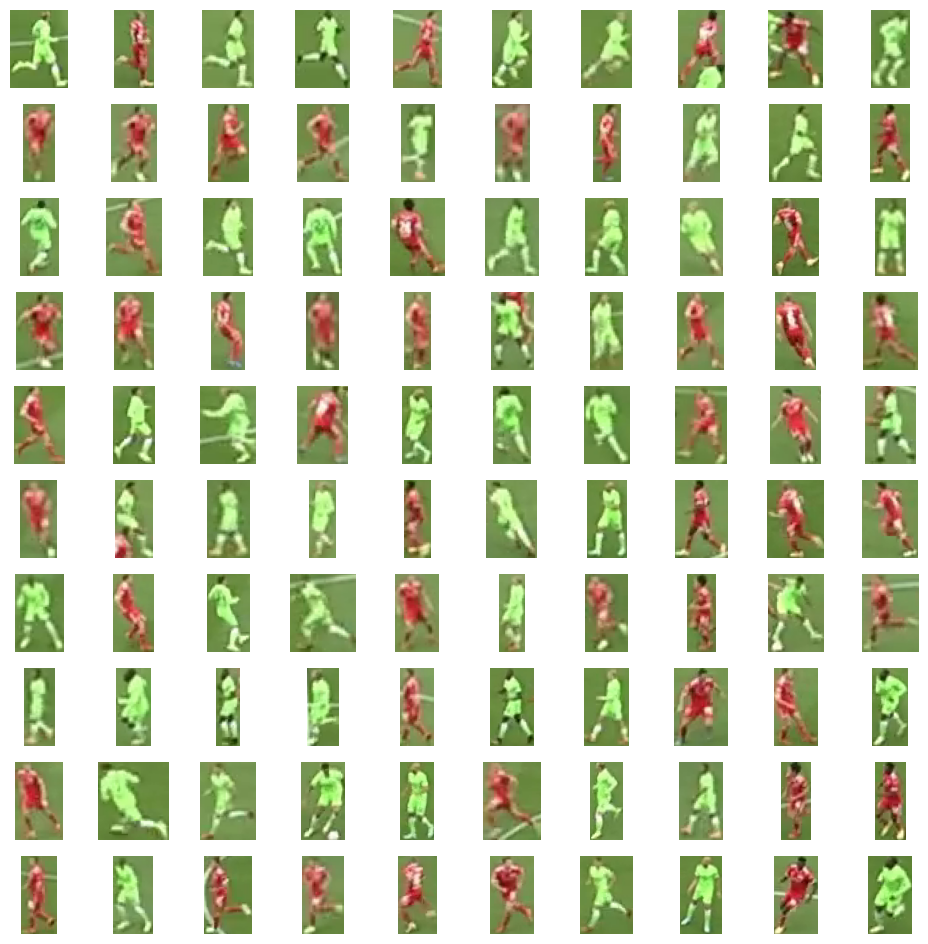

In [19]:
crops = extract_crops(SOURCE_VIDEO_PATH)
print('Number of crops:', len(crops))
sv.plot_images_grid(crops[:100], grid_size=[10,10])

In [20]:
BATCH_SIZE = 32
# Convert from numpy arrays (OpenCV) to Pillow images for SigLIP Model
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = list(chunked(crops, BATCH_SIZE))
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='Embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
print('Embeddings shape:', data.shape)

Embedding extraction: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

Embeddings shape: (478, 768)


In [21]:
REDUCER = umap.UMAP(n_components=3)  # Reduce to 3D space
CLUSTERING_MODEL = KMeans(n_clusters=2)
projections = REDUCER.fit_transform(data)
print('Projections shape:', projections.shape)

Projections shape: (478, 3)


In [22]:
clusters = CLUSTERING_MODEL.fit_predict(projections)
print('Clusters:', clusters)

Clusters: [0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0
 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0
 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1
 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1
 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1
 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0
 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0
 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0
 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0
 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0]


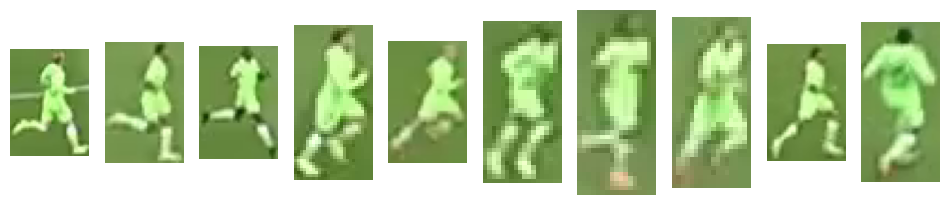

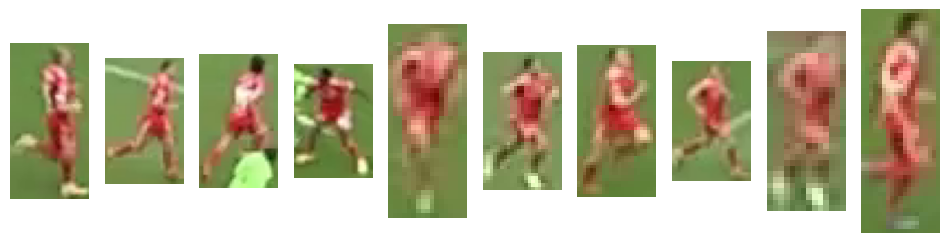

In [23]:
team_0 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]
team_1 = [crop for crop, cluster in zip(crops, clusters) if cluster == 1]
sv.plot_images_grid(team_0[:10], grid_size=[1,10])
sv.plot_images_grid(team_1[:10], grid_size=[1,10])

In [24]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='Collecting crops for team classification'):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

Embedding extraction: 18it [00:04,  3.96it/s]


### Models Loaded and Fine-tuned. Running code:

In [25]:
def get_player_in_possession(f: FrameDetections, proximity):
    if len(f.ball_detections) != 1:
        return -1
    ball_centers = f.ball_detections.get_anchors_coordinates(sv.Position.CENTER)
    ball_center = ball_centers[0]
    players_xy = f.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    min_distance = np.linalg.norm(players_xy[0] - ball_center)
    player = -1
    for player_xy, player_id in zip(players_xy, f.players_detections.tracker_id):
        distance = np.linalg.norm(player_xy - ball_center)
        if distance < min_distance:
            min_distance = distance
            player = player_id
    if min_distance <= proximity:
        return player
    return -1

In [26]:
def find_last_defender(f, p):
    last_defender = {}
    potential_offside = []
    if len(p.pitch_players_xy) > 0:
        if np.mean(p.pitch_team0_players_xy[:, 0]) < np.mean(p.pitch_team1_players_xy[:, 0]):
            last_defender[0] = np.min(p.pitch_team0_players_xy[:, 0])
            last_defender[1] = np.max(p.pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(p.pitch_team0_players_xy, f.players_detections[f.players_detections.class_id == 0].tracker_id):
                if pos[0] > last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(p.pitch_team1_players_xy, f.players_detections[f.players_detections.class_id == 1].tracker_id):
                if pos[0] < last_defender[0]:
                    potential_offside.append(tracker)
            
        else:
            last_defender[0] = np.max(p.pitch_team0_players_xy[:, 0])
            last_defender[1] = np.min(p.pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(p.pitch_team0_players_xy, f.players_detections[f.players_detections.class_id == 0].tracker_id):
                if pos[0] < last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(p.pitch_team1_players_xy, f.players_detections[f.players_detections.class_id == 1].tracker_id):
                if pos[0] > last_defender[0]:
                    potential_offside.append(tracker)

        
    else:
        last_defender = None 

    
    return last_defender, potential_offside

In [27]:
def frame_annotation(frame, f: FrameDetections, previous_possesion=None, offside=False, last_defender_positions=None, potential_offsides=[]):
    
    POSSESION_ID = get_player_in_possession(f, proximity=PLAYER_IN_POSSESSION_PROXIMITY)
    
    if offside:
        if last_defender_positions is None:
            last_defender_positions, potential_offsides = find_last_defender(f, p)
        offside_mask = np.isin(f.all_detections.tracker_id, potential_offsides)
        offside_detections = f.all_detections[offside_mask]
        non_offside_detections = f.all_detections[~offside_mask]
        offside_labels = [f"#{tid}" for tid in offside_detections.tracker_id]
        non_offside_labels = [f"#{tid}" for tid in non_offside_detections.tracker_id]
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=non_offside_detections)
        annotated_frame = offside_ellipse_annotator.annotate(scene=annotated_frame, detections=offside_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=f.ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=non_offside_detections, labels=non_offside_labels)
        annotated_frame = offside_label_annotator.annotate(scene=annotated_frame, detections=offside_detections, labels=offside_labels)
 
        offside_points = np.array([[last_defender_positions[0],0],
                                   [last_defender_positions[0], CONFIG.width],
                                   [last_defender_positions[1],0],
                                   [last_defender_positions[1], CONFIG.width]])
        
        frame_coordinates = p.transformer_inverse.transform_points(points=offside_points)
        key_points = sv.KeyPoints(xy=frame_coordinates[np.newaxis, ...])
        
        edges = [(0, 3), (1, 2)]
        edge_annotator = sv.EdgeAnnotator(
            color=sv.Color.from_hex('#00BFFF'),
            thickness=2, 
            edges=edges
        )
        
        annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)
        annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=key_points)
    else:
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=f.all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=f.ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=f.all_detections, labels=f.labels)
    

    if POSSESION_ID != -1:
            if len(f.ball_detections) == 0 and previous_possesion is not None:
                possesion_detection = previous_possesion
            else: 
                possesion_detection = f.all_detections[f.all_detections.tracker_id == POSSESION_ID]
                possesion_detection.xyxy = sv.pad_boxes(xyxy=possesion_detection.xyxy, px=10)
                previous_possesion = possesion_detection
            annotated_frame = player_triangle_annotator.annotate(scene=annotated_frame, detections=possesion_detection)
            
            
    return annotated_frame, previous_possesion

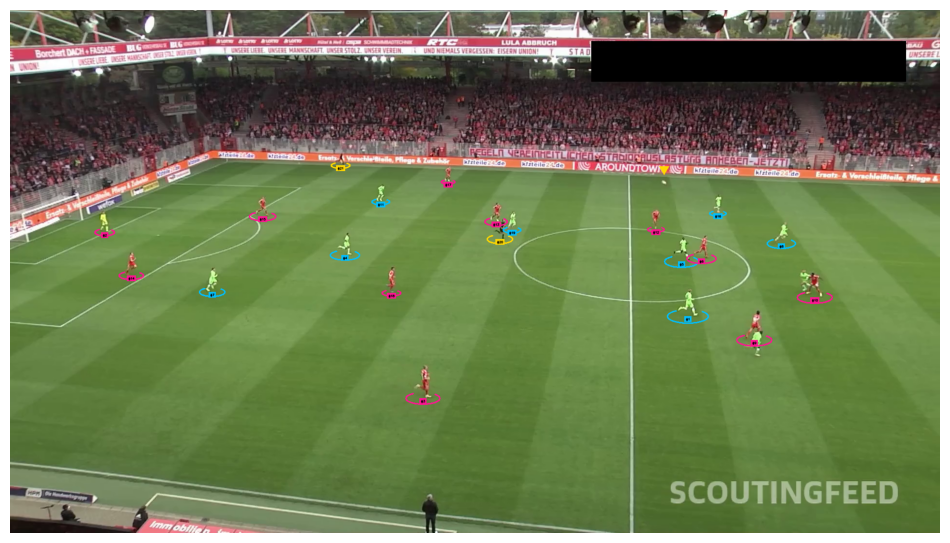

In [28]:
tracker = sv.ByteTrack()
tracker.reset()
frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result) 
f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
output,_ = frame_annotation(frame, f)
sv.plot_image(output)

### Detecting Pitch for Homography:

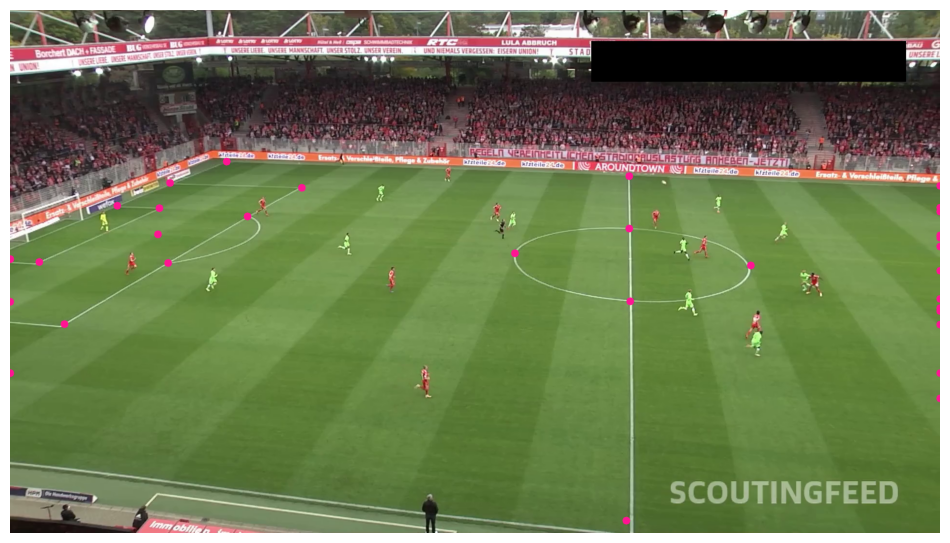

In [29]:
frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)

sv.plot_image(annotated_frame)

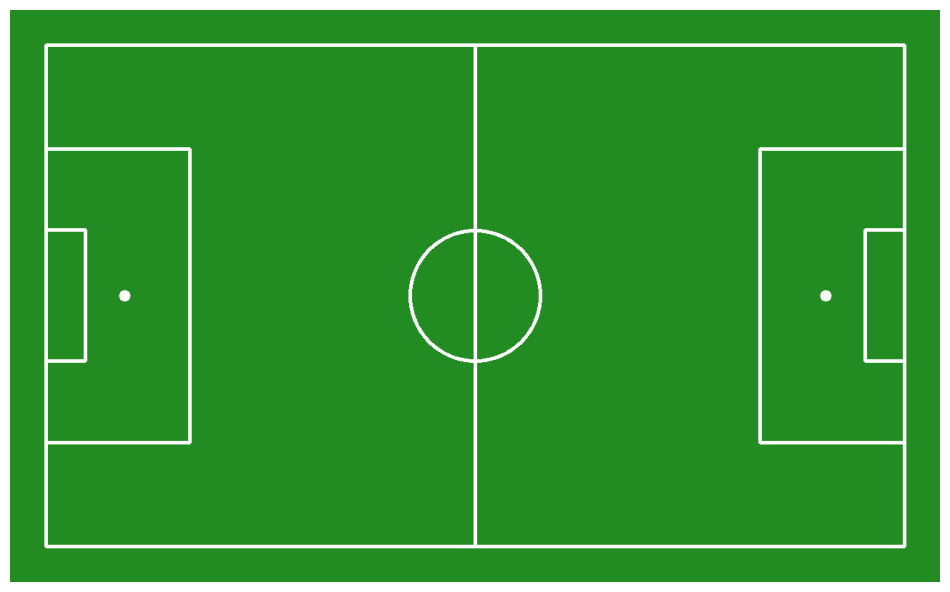

In [30]:
CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

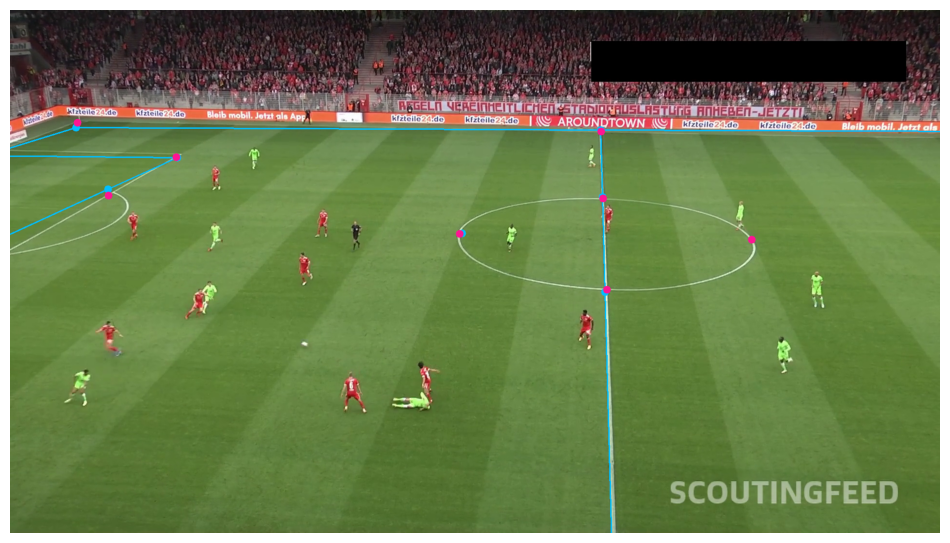

In [31]:
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, 
    edges=CONFIG.edges
)
frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200))

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [32]:
def homography_pitch(frame, f: FrameDetections, p: PitchDetections, offside=False, last_defender_positions=None, potential_offsides=[]):    
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_all_players_xy[f.all_players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_all_players_xy[f.all_players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_referees_xy,
        face_color=sv.Color.from_hex('FFD700'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    if offside:
        if last_defender_positions is None:
            last_defender_positions, potential_offsides = find_last_defender(f, p)
        offside_mask = np.isin(f.all_detections.tracker_id, potential_offsides)
        x_coord = last_defender_positions[0]
        vertical_line_path = np.array([
            [x_coord, 0],
            [x_coord, CONFIG.width]
        ])
        
        annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
        x_coord = last_defender_positions[1]
        
        vertical_line_path = np.array([
            [x_coord, 0],
            [x_coord, CONFIG.width]
        ])
        annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
    return annotated_frame

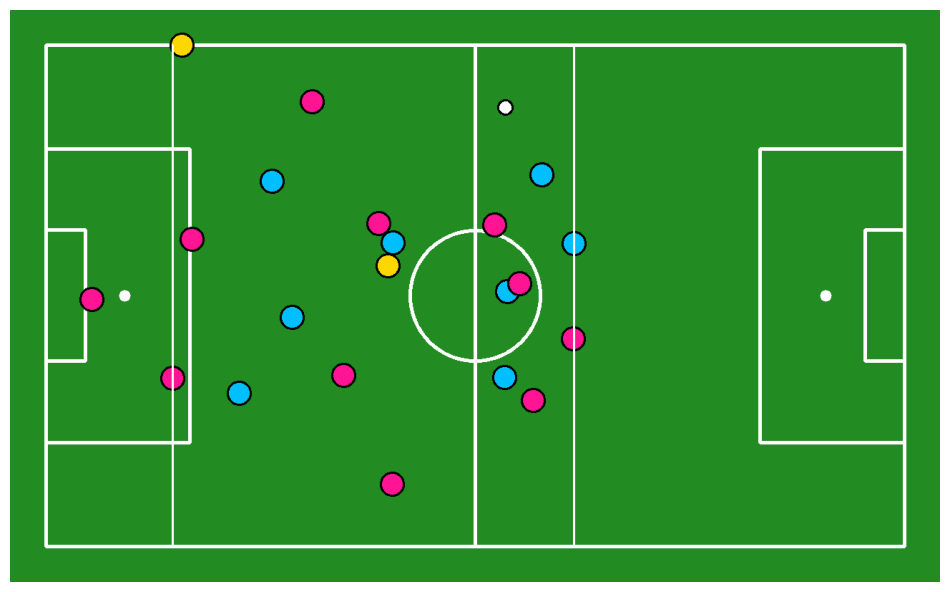

In [33]:
tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)
f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
p = PitchDetections(frame, f, key_points=key_points)
sv.plot_image(homography_pitch(frame, f, p, offside=True))

In [34]:
def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
    ) -> np.ndarray:

    if pitch is None:
        pitch = draw_pitch(config=config, padding=padding, scale=scale)

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((scaled_width + 2 * padding, scaled_length + 2 * padding))

    y_coordinates -= padding
    x_coordinates -= padding
    
    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    steepness = 15  # Sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    for c in range(3):
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] + (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

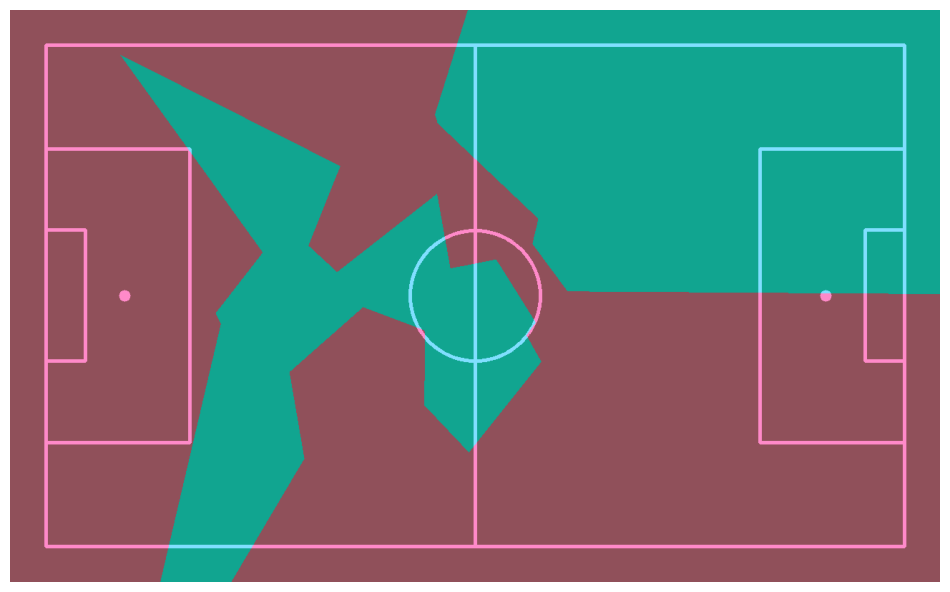

In [35]:
annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=p.pitch_players_xy[f.players_detections.class_id == 0],
    team_2_xy=p.pitch_players_xy[f.players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

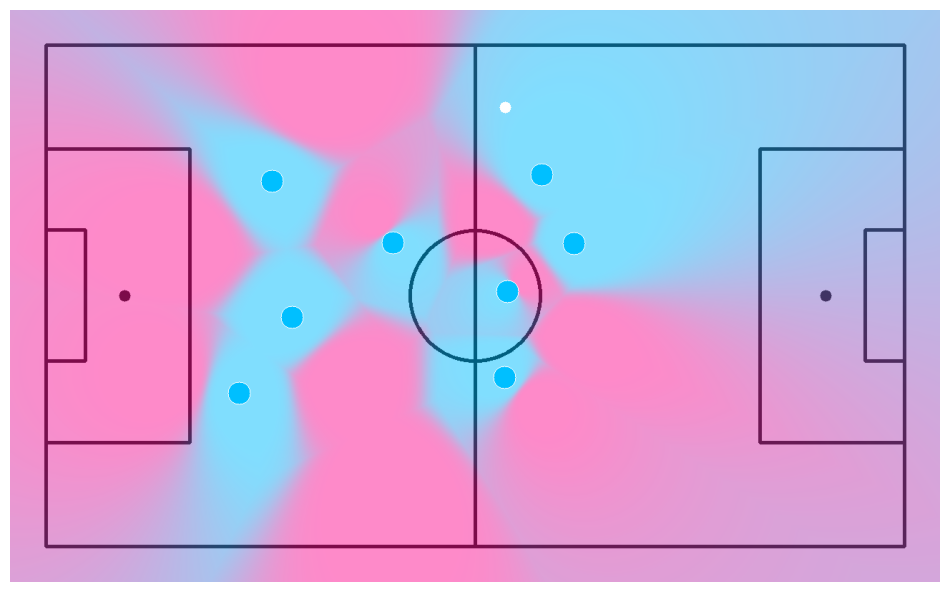

In [36]:
annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=p.pitch_players_xy[f.players_detections.class_id == 0],
    team_2_xy=p.pitch_players_xy[f.players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=p.pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=p.pitch_players_xy[f.players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=p.pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

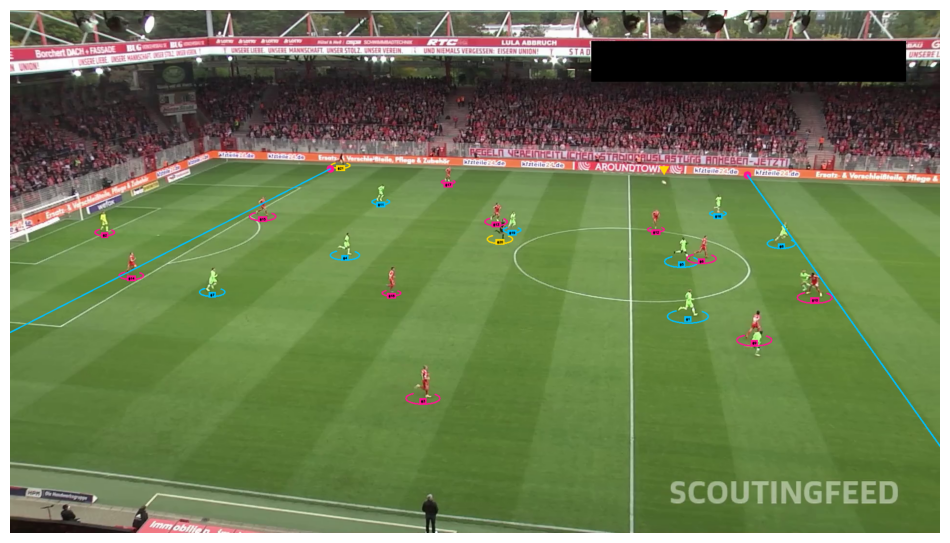

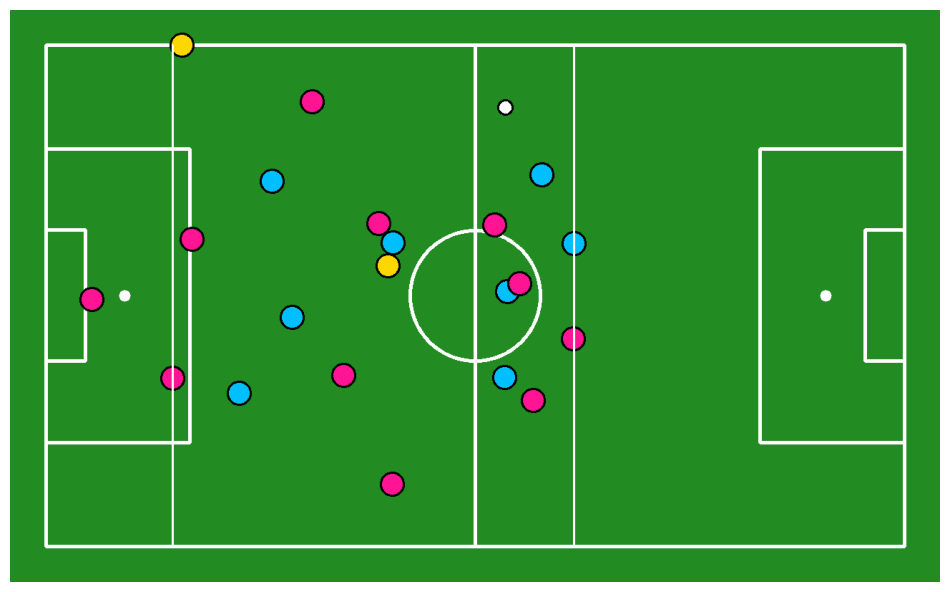

In [37]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"

tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))

result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result) 

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
p = PitchDetections(frame, f, key_points=key_points)
last_defender_positions, potential_offsides = find_last_defender(f, p)
sv.plot_image(frame_annotation(frame, f, offside=True, last_defender_positions=last_defender_positions, potential_offsides=potential_offsides)[0])
sv.plot_image(homography_pitch(frame, f, p, offside=True, last_defender_positions=last_defender_positions, potential_offsides=potential_offsides))

In [38]:
def lighten_color(hex_color, factor=0.3):
    # Convert hex to RGB tuple
    rgb = tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    # Increase each channel by the factor (ensuring not to exceed 255)
    lighter_rgb = tuple(min(255, int(c + (255 - c) * factor)) for c in rgb)
    # Convert back to hex
    return '#{:02x}{:02x}{:02x}'.format(*lighter_rgb)


In [ ]:
# Only video of detection
tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
        output = frame_annotation(frame, f)
        video_sink.write_frame(output)
print('Video Made.')

In [44]:
def interpolate_ball_positions(ball_positions):
    ball_positions = [x.get(1,{}).get('bbox',[]) for x in ball_positions]
    df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

    # Interpolate missing values
    df_ball_positions = df_ball_positions.interpolate()
    df_ball_positions = df_ball_positions.bfill()

    ball_positions = [{1: {"bbox":x}} for x in df_ball_positions.to_numpy().tolist()]

    return ball_positions

In [47]:
# team_colors=['#00BFFF', '#FF1493']
# This example assumes that players_detections.class_id indicates the team index (0 or 1)
# offside_colors = []
# for team_id in offside_detections.class_id:
#     base_color = team_colors[int(team_id)]
#     offside_colors.append(lighten_color(base_color, factor=0.3))

# offside_palette = sv.ColorPalette.from_hex(offside_colors)
record = []
tracker = sv.ByteTrack()
tracker.reset()

CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = 30
frame_height, frame_width = pitch_frame.shape[:2]
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/offside.mp4", video_info=video_info)
video_writer1 = cv2.VideoWriter('/kaggle/working/offside_pitch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
# video_writer2 = cv2.VideoWriter('/kaggle/working/output_video2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
# video_writer3 = cv2.VideoWriter('/kaggle/working/output_video3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
start_time = time.time()
previous_possesion = None
frame_number = 0
team0possesion = 0
team1possesion = 0
team0passes = 0
team1passes = 0

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result) 
    
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
     
    frame_info = {
    'frame': frame_number,
    'detections': detections,
    'keypoints': key_points
    }

    # Append the current frame's data to the list
    record.append(frame_info)

    frame_number += 1

    ball_positions = []


# Define the buffer size for recent positions
buffer_size = 10
recent_positions = deque(maxlen=buffer_size)

ball_positions = []

for frame_info in record:
    detections = frame_info['detections']
    # Filter for ball detections using BALL_ID
    ball_detections = detections[detections.class_id == BALL_ID]
    
    if len(ball_detections) > 0:
        # Calculate the center for each detection from its bbox [x1, y1, x2, y2]
        centers = []
        for bbox in ball_detections.xyxy:
            x1, y1, x2, y2 = bbox
            center = ((x1 + x2) / 2, (y1 + y2) / 2)
            centers.append(center)
        centers = np.array(centers)
        
        # If we have previous positions, compute their centroid; otherwise, default to the first detection.
        if recent_positions:
            centroid = np.mean(np.array(recent_positions), axis=0)
            distances = np.linalg.norm(centers - centroid, axis=1)
            best_index = np.argmin(distances)
        else:
            best_index = 0
        
        # Select the best detection's bbox and update recent positions with its center
        best_bbox = ball_detections.xyxy[best_index]
        best_center = centers[best_index]
        recent_positions.append(best_center)
        
        ball_positions.append({1: {"bbox": best_bbox}})
    else:
        # If no ball is detected, append a placeholder with NaN values.
        ball_positions.append({1: {"bbox": [np.nan, np.nan, np.nan, np.nan]}})

# Now, ball_positions is a list ready to be passed to the interpolate_ball_positions function
interpolated_ball_positions = interpolate_ball_positions(ball_positions)

for frame_info, ball_pos in zip(record, interpolated_ball_positions):
    detections = frame_info['detections']
    ball_detections = detections[detections.class_id == BALL_ID]
    other_detections = detections[detections.class_id != BALL_ID]
    if len(ball_detections)==0 or len(ball_detections)>1:
        print('gehgfu4egf')
        ball_position = ball_pos.get(1,{}).get('bbox',[])
        print(ball_pos)
        print(ball_position)
        ball_detection = sv.Detection(xyxy=ball_position, class_id=BALL_ID, confidence=0.7)
    detections = other_detections+ball_detections
    frame_info['detections'] = detections
record2 = []  
with video_sink1:
    for frame, frame_record in zip(tqdm(frame_generator, total=video_info.total_frames), record):
        detections = frame_info['detections']
        
        key_points = frame_info['keypoints']
        frame_number = frame_info['frame_number']
        f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
        p = PitchDetections(frame, f, key_points=key_points)
        
        last_defender_positions, potential_offsides = find_last_defender(f, p)
        output, possesion=frame_annotation(frame, f, offside=True, last_defender_positions=last_defender_positions, potential_offsides=potential_offsides,  previous_possesion = previous_possesion)
        if possesion is not None:
            if possesion.tracker_id in potential_offsides:
                print('OFFSIDE!')
            if possesion.class_id == 0:
                team0possesion += 1
                if previous_possesion is not None:
                    if previous_possesion.class_id == 0:
                        team0passes += 1
            else:
                team1possesion += 1
                if previous_possesion is not None:
                    if previous_possesion.class_id == 1:
                        team1passes += 1
            
            previous_possesion = possesion

        frame_info = {
        'frame': frame_number,
        'player': possesion,
        'potential_offsides': potential_offsides
        }
    
        # Append the current frame's data to the list
        record2.append(frame_info)

        video_sink1.write_frame(output)
        video_writer1.write(homography_pitch(frame, f, p, offside=True, last_defender_positions=last_defender_positions, potential_offsides=potential_offsides))
        
  
video_writer1.release()
print("--- %s seconds ---" % (time.time() - start_time))
print('---POSSESSION:---')
print('Team 0: '+str(team0possesion*100/(team0possesion+team1possesion)))
print('Team 1: '+str(team1possesion*100/(team0possesion+team1possesion)))
print('---PASSES:---')
print('Team 0: '+str(team0passes))
print('Team 1: '+str(team1passes))
print('---RECORD:---')
print(record)
print('---RECORD2:---')
print(record2)

100%|██████████| 750/750 [02:35<00:00,  4.82it/s]


TypeError: unsupported operand type(s) for +: 'Detections' and 'Detections'

In [ ]:
# Creates final video output
OUTPUT_VIDEO_PATH = "output_video.mp4"
TARGET_VIDEO_PATH = "result5.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = 30
frame_height, frame_width = pitch_frame.shape[:2]
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/sink1.mp4", video_info=video_info)
video_writer1 = cv2.VideoWriter('/kaggle/working/output_video1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer2 = cv2.VideoWriter('/kaggle/working/output_video2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer3 = cv2.VideoWriter('/kaggle/working/output_video3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

with video_sink1:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)
        
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
        
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        
        referees_detections.class_id -= 1
        
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
        all_detections.class_id = all_detections.class_id.astype(int)
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        
        video_sink1.write_frame(annotated_frame)
        
        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])
        
        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)
        
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
        
        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
        
        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)
        
        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        
        video_writer1.write(annotated_frame)
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_pitch_voronoi_diagram(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        video_writer2.write(annotated_frame)
        
        annotated_frame = draw_pitch(
            config=CONFIG,
            background_color=sv.Color.WHITE,
            line_color=sv.Color.BLACK
        )
        annotated_frame = draw_pitch_voronoi_diagram_2(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.WHITE,
            radius=8,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame
        )
        
        video_writer3.write(annotated_frame)

video_writer1.release()
video_writer2.release()
video_writer3.release()